# Tugas 2
Buatlah model klasifikasi dengan menggunakan SVM berdasarkan data percobaan 5 dengan menggunakan fitur histogram

### Langkah 1: Import library yang diperlukan

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
import os

In [4]:
train_dir = "images/training"
test_dir = "images/test"

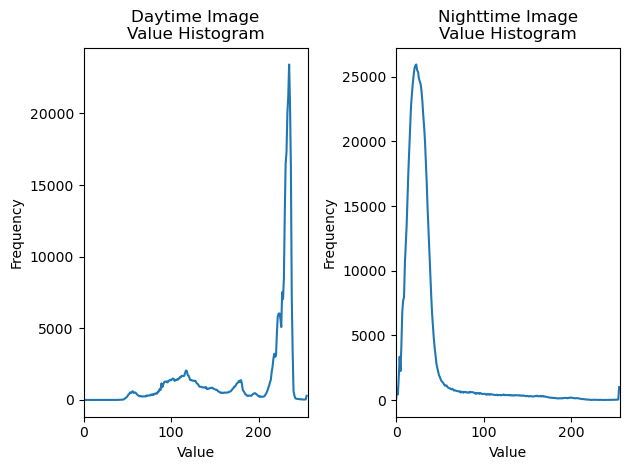

In [10]:
day_img = cv2.imread('images/test/day/20151101_152050.jpg')
night_img = cv2.imread('images/test/night/20151101_072507.jpg')

# Convert
day_hsv = cv2.cvtColor(day_img, cv2.COLOR_BGR2HSV)
night_hsv = cv2.cvtColor(night_img, cv2.COLOR_BGR2HSV)

# Extract
day_v = day_hsv[:,:,2]
night_v = night_hsv[:,:,2]

# Calculate
day_hist = cv2.calcHist([day_v], [0], None, [256], [0, 256])
night_hist = cv2.calcHist([night_v], [0], None, [256], [0, 256])

# Plot Histogram
plt.figure()

# Daytime Image
plt.subplot(1, 2, 1)
plt.title("Daytime Image\nValue Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(day_hist)
plt.xlim([0, 256])

# Nighttime Image
plt.subplot(1, 2, 2)
plt.title("Nighttime Image\nValue Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(night_hist)
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

### Langkah 2: Fungsi untuk Menghitung Histogram

In [11]:
def compute_histogram(image):
    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Compute the histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [16, 16, 16], [0, 180, 0, 256, 0, 256])

    # Normalize the histogram
    cv2.normalize(hist, hist)

    # Flatten the histogram to create the feature vector
    return hist.flatten()

In [13]:
def standarized_input(image):
    # resize
    std_img = cv2.resize(image, (1100, 600))

    return std_img

### Langkah 3: Fungsi untuk Membaca Gambar dan Label

In [14]:
def load_data(directory):
    data = []
    labels = []

    for label in ['day', 'night']:
        path = os.path.join(directory, label)
        for filename in os.listdir(path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(path, filename)

                # Read and resize
                image = cv2.imread(img_path)
                resized_image = standarized_input(image)

                # Compute histogram features
                hist = compute_histogram(resized_image)

                # Append features and label
                data.append(hist)
                labels.append(0 if label == 'night' else 1) # 0 for night, 1 for day

    return np.array(data), np.array(labels)

### Langkah 4: Split Data train dan test

In [15]:
train_data, train_labels = load_data(train_dir)
test_data, test_labels = load_data(test_dir)

### Langkah 5: Membuat Pipeline dengan PCA dan SVM

In [18]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('svm', SVC)
])

In [19]:
print(train_data[0])
print(train_labels[0])

type(train_labels)

[0. 0. 0. ... 0. 0. 0.]
1


numpy.ndarray

### Langkah 6: Melakukan Grid Search untuk Hyperparameter Tuning

In [23]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Create a pipeline with PCA and SVM
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('svm', svm.SVC())
])

# Define the parameter grid for GridSearch
param_grid = {
    'pca__n_components': [10, 20, 30, 50, 100, 150],  # Number of PCA components
    'svm__C': [0.1, 1, 10],                 # Regularization parameter for SVM
    'svm__kernel': ['linear', 'rbf']         # Kernel types
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Fit the model on training data
grid_search.fit(train_data, train_labels)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'pca__n_components': 50, 'svm__C': 10, 'svm__kernel': 'linear'}
0.975


### Langkah 7: Evaluasi Model dan Hasil Terbaik

In [24]:
# Get the best model from GridSearch
best_model = grid_search.best_estimator_

# Predict on train data
train_predictions = best_model.predict(train_data)
# Predict on test data
test_predictions = best_model.predict(test_data)

# Evaluate accuracy
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 99.38%


In [25]:
# export the model
import joblib
joblib.dump(best_model, 'model.pkl')

['model.pkl']

In [ ]:
# Test dengan OpenCV

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    resized_frame = standarized_input(frame)
    hist = compute_histogram(resized_frame)
    pred = best_model.predict([hist])
    cv2.putText(frame, 'Day' if pred == 1 else 'Night', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)